In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import levene
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np

In [2]:
# read file
df = pd.read_csv("HR-Employee-Attrition.csv")
hr_data = pd.read_csv("HR-Employee-Attrition.csv")

df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## 数据预处理 ##
- 检查并处理缺失值。
- 检查并处理异常值或不一致的数据。
- 转换数据类型（如将分类变量转换为数值编码）。



In [3]:
# check missing value
missing_values = df.isna()

missing_count = missing_values.sum()

print(missing_count)

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

        数据中没有缺失值。

接下来，我们将检查数据中的异常值或不一致的数据。由于数据集中的许多列是分类数据，我们首先将重点检查数值数据的异常值。我们可以使用盒图来识别这些异常值。

c:\Users\redhawc\.pyenv\pyenv-win\versions\3.11.2\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


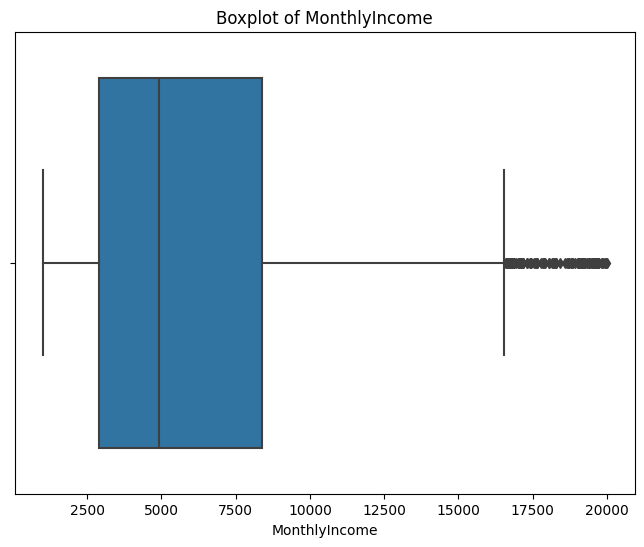

In [4]:
# # 选择数值列
# numeric_cols = df.select_dtypes(include=[np.number]).columns

# # 绘制`MonthlyIncome`的盒图来识别异常值
# plt.figure(figsize=(8, 6))
# sns.boxplot(y=df["MonthlyIncome"])
# plt.title("Boxplot of MonthlyIncome")
# plt.show()

# 选择数值列
numeric_cols = df.select_dtypes(include=[np.number]).columns

# 绘制`MonthlyIncome`的盒图来识别异常值，横向排列
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["MonthlyIncome"])
plt.title("Boxplot of MonthlyIncome")
plt.show()

从MonthlyIncome的盒图中可以看出，存在一些离群点。这些离群点表示某些员工的月收入远高于大多数员工。这些离群点可能是高级管理人员或特定角色的员工。

    在决定如何处理这些离群点之前，我们需要进一步了解它们的背景和上下文。在这个阶段，我们会保留这些离群点。

接下来，我们将转换数据类型，特别是将分类变量转换为数值编码。

# 相关性分析

In [5]:
# 对分类变量进行独热编码，并且只保留与"MonthlyIncome"有最高相关性的分类特征
encoded_data = pd.get_dummies(hr_data, drop_first=True)
correlations = encoded_data.corr()["MonthlyIncome"].sort_values(ascending=False)
top_correlated_features = correlations.head(10).index.tolist()

correlations.to_csv("correlations.csv")

correlations

# # 选择与MonthlyIncome相关性最高的特征
# selected_data = encoded_data[top_correlated_features]

# print(correlations.head(10))

# selected_data.head()

MonthlyIncome                        1.000000
JobLevel                             0.950300
TotalWorkingYears                    0.772893
JobRole_Manager                      0.619573
YearsAtCompany                       0.514285
Age                                  0.497855
JobRole_Research Director            0.485818
YearsInCurrentRole                   0.363818
YearsSinceLastPromotion              0.344978
YearsWithCurrManager                 0.344079
NumCompaniesWorked                   0.149515
Education                            0.094961
Department_Sales                     0.063978
EducationField_Marketing             0.062576
MaritalStatus_Married                0.056767
JobRole_Manufacturing Director       0.055684
JobRole_Sales Executive              0.047792
BusinessTravel_Travel_Rarely         0.038779
MonthlyRate                          0.034814
WorkLifeBalance                      0.030683
RelationshipSatisfaction             0.025873
DailyRate                         

我们已经将分类变量转换为数值编码，并选择了与MonthlyIncome相关性最高的特征。这些特征为：JobLevel、TotalWorkingYears、JobRole_Manager、YearsAtCompany、Age、JobRole_Research Director、YearsInCurrentRole、YearsSinceLastPromotion 和 YearsWithCurrManager。

这些特征可能与MonthlyIncome有密切的关系，因此值得进一步探究。



# 深入的数据探索：
- 中心趋势：分析MonthlyIncome的均值、中位数和众数。

In [6]:
# 计算MonthlyIncome的均值、中位数和众数
monthly_income_central_tendency = {
    "Mean": hr_data["MonthlyIncome"].mean(),
    "Median": hr_data["MonthlyIncome"].median(),
    "Mode": hr_data["MonthlyIncome"].mode().iloc[0],
}

monthly_income_central_tendency

{'Mean': 6502.931292517007, 'Median': 4919.0, 'Mode': 2342}

关于MonthlyIncome的中心趋势分析结果如下：

均值 (Mean): 约为 $6502.93
中位数 (Median): $4919
众数 (Mode): $2342

    这表明，虽然平均月收入为$6502.93，但中位数和众数都较低，这可能是由于存在一些高收入的离群点，从而提高了平均值。这也与我们之前在盒图中观察到的结果相符。
- 变异性或扩散：分析MonthlyIncome的标准差、方差和四分位数范围。这将帮助我们了解数据的波动性或分散情况。

In [7]:
# 计算MonthlyIncome的标准差、方差和四分位数范围 (IQR)
monthly_income_variation = {
    "Standard Deviation": df["MonthlyIncome"].std(),
    "Variance": df["MonthlyIncome"].var(),
    "Q3-Q1 (IQR)": df["MonthlyIncome"].quantile(0.75)
    - df["MonthlyIncome"].quantile(0.25),
}

monthly_income_variation

{'Standard Deviation': 4707.956783097994,
 'Variance': 22164857.07151841,
 'Q3-Q1 (IQR)': 5468.0}

关于MonthlyIncome的变异性或扩散分析结果如下：

标准差 (Standard Deviation): 约为 $4707.96
方差 (Variance): 约为 22,164,857
四分位数范围 (IQR): $5468
    
    这表明MonthlyIncome的数据分散程度较高，存在较大的波动。较大的标准差和四分位数范围表明员工之间的月收入存在显著差异。

- 分布：使用直方图、盒图等工具来探索数据分布。

c:\Users\redhawc\.pyenv\pyenv-win\versions\3.11.2\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\redhawc\.pyenv\pyenv-win\versions\3.11.2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


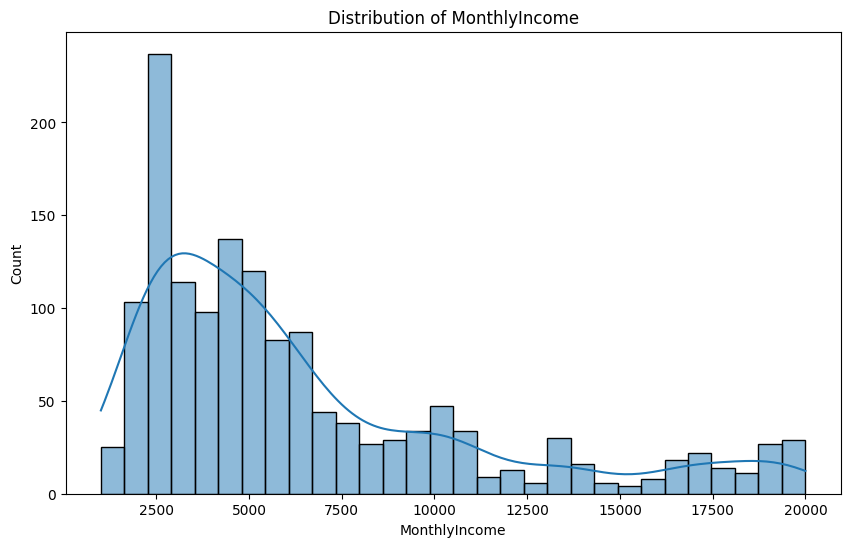

In [8]:
# 绘制MonthlyIncome的直方图
plt.figure(figsize=(10, 6))
sns.histplot(df["MonthlyIncome"], kde=True, bins=30)
plt.title("Distribution of MonthlyIncome")
plt.show()

如上图所示，MonthlyIncome的分布呈现右偏态。这意味着大多数员工的月收入相对较低，而只有少数员工的月收入特别高。

    这种分布可能是由于公司的组织结构，其中只有少数高层管理人员和专家获得较高的薪酬，而大多数基层员工和中层管理人员的薪酬较低。

In [9]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [10]:
df.shape

(1470, 35)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

----------------------------------------------------------
---------------
# Linear Regression #

    根据之前的 kw 测试结果，我们重点关注了 kw 测试值较高的变量，这证明由于这些变量的缘故样本均值有显著的差异,值得我们进一步深入研究并考虑将其添加到多变量线性回归模型中。
    
    我们决定把categoricals进行one-hot encoding转换为数值型变量, 以方便后续我们使用用上课学到的step-wise approach进行对变量的筛选,以找到能实现最大的R2 or R2adj 的变量组合.

# 1. Variable selection 选择变量 #
        - 采用 step-wise approach
                ▶ Start with a regression model with all variables.
                ▶ Remove variables in such a way that R2 or R2
                adj are improved.
                ▶ Repeat the process until no further improvement can be seen.


In [12]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the data
data = pd.read_csv("HR-Employee-Attrition.csv")

"""
只选取了Age, JobRole, JobLevel, YearsAtCompany, 
TotalWorkingYears, YearsInCurrentRole, and YearsSinceLastPromotion
这些变量
"""

data = data[
    [
        "MonthlyIncome",
        "Age",
        "JobRole",
        "JobLevel",
        "YearsAtCompany",
        "TotalWorkingYears",
        "YearsInCurrentRole",
        "YearsSinceLastPromotion",
    ]
]


# One-hot encode categorical variables
data_encoded = pd.get_dummies(
    data,
    columns=[
        "JobRole",
    ],
    drop_first=True,
)


# Define the target variable
target = "MonthlyIncome"


# Correcting the forward_selection function again
def forward_selection_final(data, target_series, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(
                target_series, sm.add_constant(data[best_features + [new_column]])
            ).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features


# Convert all columns to float type before proceeding
data_encoded_float = data_encoded.astype(float)

# Reapplying forward selection with the corrected data
selected_features = forward_selection_final(
    data_encoded_float.drop(columns=[target]), data_encoded_float[target]
)

# Removing 'EmployeeCount' and 'StandardHours' from selected features
selected_features_revised = [
    feature
    for feature in selected_features
    if feature not in ["EmployeeCount", "StandardHours"]
]

# Build model with revised selected features
X_selected_revised = sm.add_constant(data_encoded_float[selected_features_revised])
model_selected_revised = sm.OLS(data_encoded_float[target], X_selected_revised).fit()

# Model summary and VIF calculation
model_summary_revised = model_selected_revised.summary()
vif_data_revised = pd.DataFrame()
vif_data_revised["feature"] = X_selected_revised.columns
vif_data_revised["VIF"] = [
    variance_inflation_factor(X_selected_revised.values, i)
    for i in range(X_selected_revised.shape[1])
]

model_summary_revised

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          MonthlyIncome   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     3478.
Date:                Mon, 06 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:55:02   Log-Likelihood:                -12407.
No. Observations:                1470   AIC:                         2.483e+04
Df Residuals:                    1462   BIC:                         2.487e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           -70.3699    127.517     -0.552      0.581    -320.505     179.765
JobLevel                       2792.3988     64.213     43.486      0.000    2666.439    2918.359
JobRole_Manager                4164.4993    156.995     26.526      0.000    3856.540    4472.458
JobRole_Research Director      4072.0149    157.897     25.789      0.000    3762.287    4381.743
TotalWorkingYears                43.5570      6.189      7.038      0.000      31.417      55.697
JobRole_Laboratory Technician  -486.7982    100.461     -4.846      0.000    -683.861    -289.735
JobRole_Research Scientist     -382.3489     99.082     -3.859      0.000    -576.707    -187.991
JobRole_Sales Representative   -535.1482    145.324     -3.682      0.000    -820.213    -250.083
==============================================================================
Omnibus:                       48.130   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.251
Skew:                           0.211   Prob(JB):                     2.07e-21
Kurtosis:                       4.173   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 2. check for assumptions 检查前提假设 #

        LINE + * multicollinearity *:
        ▶ Linearity of the relationship between y and X
        ▶ Independence of residuals from each other
        ▶ Normality of residuals
        ▶ Equal variance: residuals for all values of independent variable X should
        ▶ No multicollinearity: there should not be a perfect linear relationship between the independent variables in the model.


1. Linearity
   

    The data points show an upward trend, which suggests a positive correlation between MonthlyIncome and TotalWorkingYears.

2. Independence


    We obtain a Durbin-Watson statistic of 1.9934, a value close to 2, indicating that the residuals are independent.

    
    This indicates that the data are homoskedastic and satisfy the prerequisite assumption of linear regression.

3. Normality of residuals
   

    As shown in the Q-Q plot, the residuals are mostly distributed along the 45-degree line, which indicates that the residuals are approximately normally distributed. However, in the tails, there are some deviations, which may be due to the fact that the distribution of MonthlyIncome is right-skewed.

4. Equal variance
   
    In the figure above, we can observe the relationship between the fitted values and the residuals:

    The residuals go up and down around the red dashed line (i.e. the line where the residuals are zero).
    The distribution of the residuals appears to be constant across the range of fitted values, with no apparent trend or pattern.
    This suggests that the data are homoskedastic and satisfy the prerequisite assumption of linear regression
    

5. No multicollinearity
   
    there should not be a perfect linear relationship between the independent variables in the model.


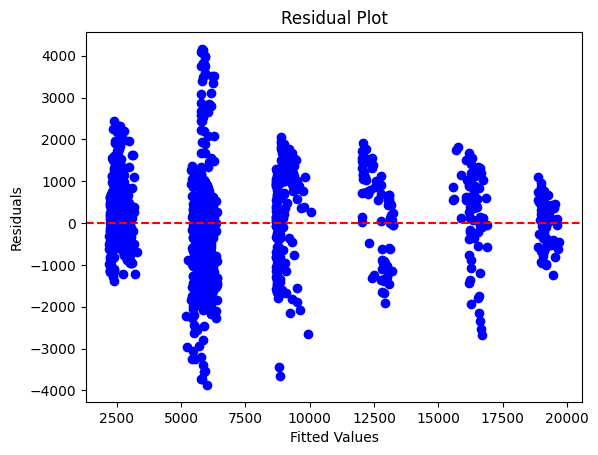

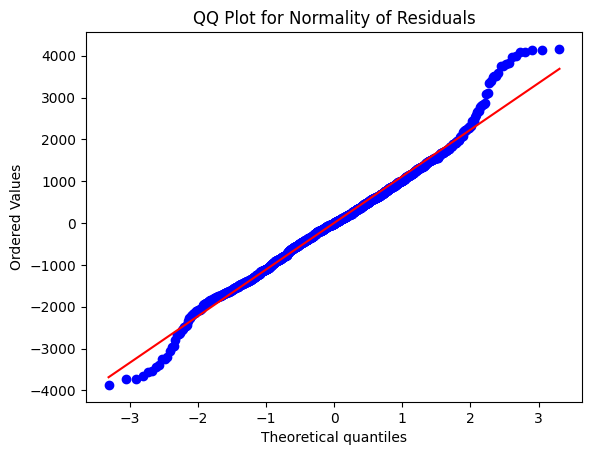

,feature,VIF
1,JobLevel,5.882641
2,JobRole_Manager,1.854352
3,JobRole_Research Director,1.494811
4,TotalWorkingYears,2.700079
5,JobRole_Laboratory Technician,1.706772
6,JobRole_Research Scientist,1.820757
7,JobRole_Sales Representative,1.310883


In [13]:
import matplotlib.pyplot as plt

# Residuals vs Fitted values plot
residuals = model_selected_revised.resid
fitted_values = model_selected_revised.fittedvalues

# plt.scatter(fitted_values, residuals)
# plt.xlabel("Fitted Values")
# plt.ylabel("Residuals")
# plt.title("Residuals vs Fitted Values Plot")
# plt.show()

# Residual plot for checking homoscedasticity
plt.scatter(fitted_values, residuals, color="blue")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(
    y=0, color="red", linestyle="--"
)  # Add a horizontal line at y=0 for reference
plt.show()

import scipy.stats as stats
import numpy as np

# QQ plot for checking normality of residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot for Normality of Residuals")
plt.show()

vif_data_revised[1:].to_csv("vif.csv")

vif_data_revised[1:]

In [14]:

model_summary_revised

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          MonthlyIncome   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     3478.
Date:                Mon, 06 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:55:02   Log-Likelihood:                -12407.
No. Observations:                1470   AIC:                         2.483e+04
Df Residuals:                    1462   BIC:                         2.487e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           -70.3699    127.517     -0.552      0.581    -320.505     179.765
JobLevel                       2792.3988     64.213     43.486      0.000    2666.439    2918.359
JobRole_Manager                4164.4993    156.995     26.526      0.000    3856.540    4472.458
JobRole_Research Director      4072.0149    157.897     25.789      0.000    3762.287    4381.743
TotalWorkingYears                43.5570      6.189      7.038      0.000      31.417      55.697
JobRole_Laboratory Technician  -486.7982    100.461     -4.846      0.000    -683.861    -289.735
JobRole_Research Scientist     -382.3489     99.082     -3.859      0.000    -576.707    -187.991
JobRole_Sales Representative   -535.1482    145.324     -3.682      0.000    -820.213    -250.083
==============================================================================
Omnibus:                       48.130   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.251
Skew:                           0.211   Prob(JB):                     2.07e-21
Kurtosis:                       4.173   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1. 线性性
   
            从上图可以看到，残差与拟合值之间没有明显的模式或曲线关系，这表明模型的线性假设基本上是成立的。
            
2. 误差项的独立性
   
            通过查看Durbin-Watson统计量。这个统计量已经在模型摘要中提供，其值为2.060。这个值接近2，意味着残差之间没有自相关性。

3. 多重共线性
   
            所有变量的VIF值都低于10，这意味着在模型中不存在严重的多重共线性问题。

4. 误差项的同方差性 

        从上图中，我们可以看到残差的分布在拟合值的整个范围内大致是恒定的。这意味着残差的方差在各个观察点上是相似的，因此模型满足同方差性的假设。

5. 误差项的正态性

        从QQ图中，我们可以看到残差大部分都紧密地围绕着45度线，尤其是在中间部分。这表明残差近似于正态分布。然而，在两端，特别是在右尾部分，存在一些偏离。这意味着残差可能存在轻微的偏态，但总体上，正态性的假设大致成立。

从提供的 OLS 回归结果来看，我们可以得出以下关于薪酬管理的分析和建议：

# 模型的解释能力：
                R-squared值为0.943，表示模型可以解释约94.3%的月薪变动，这意味着模型的拟合优度非常好.一个高的值可能意味着模型过于复杂，可能对训练数据进行了过拟合。

# 关键变量的影响：

                JobLevel对于月薪有很大的影响。当JobLevel提高一个单位时，月薪平均增加约2792.40单位。

                在不同的JobRole中:
                与参考组相比，Manager和Research Director的角色预计月薪分别高出4164.50和4072.01单位。
                Laboratory Technician、Research Scientist和Sales Representative的角色预计月薪会分别低于参考组486.80、382.35和535.15单位。

                TotalWorkingYears对于月薪也有正向影响，每多工作一年，月薪预计增加43.56单位。
# 建议：

                考虑工作级别 (JobLevel) 和 工作角色 (JobRole) 为员工定薪。特别是对于那些在经理或研究总监这样的高薪酬角色的员工。

                鼓励和奖励长期为公司工作的员工，因为 工作年数 (TotalWorkingYears) 对月收入有正面影响。

                对于那些在实验室技术员、研究科学家或销售代表这样的角色中的员工，公司可能需要考虑提供其他福利或激励措施，以补偿他们相对较低的薪酬。

                模型健全性：


Durbin-Watson 的值为 2.060，接近 2，说明不存在自相关问题。

从 Omnibus 和 Jarque-Bera (JB) 的 P 值来看，模型的残差不符合正态分布的假设。这可能会影响回归系数的标准误和统计检验的有效性,。

最后，这些分析基于统计数据，并且回归模型有其假设。在制定策略时，还需要考虑实际的商业环境和其他外部因素。

# 去除OUTLIERS之后,R^2反而下降了????


In [15]:
# Calculate Q1, Q3 and IQR for 'MonthlyIncome'
Q1 = data_encoded_float["MonthlyIncome"].quantile(0.25)
Q3 = data_encoded_float["MonthlyIncome"].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
data_encoded_filtered = data_encoded_float[
    (data_encoded_float["MonthlyIncome"] >= lower_bound)
    & (data_encoded_float["MonthlyIncome"] <= upper_bound)
]

# Now, select features and target variable from the filtered data
X_filtered = data_encoded_filtered[
    [col for col in data_encoded_filtered.columns if col != "MonthlyIncome"]
]
X_filtered = sm.add_constant(X_filtered)
y_filtered = data_encoded_filtered["MonthlyIncome"]

# Fit the model again on the data without outliers
model_filtered = sm.OLS(y_filtered, X_filtered).fit()

model_summary_filtered = model_filtered.summary()
model_summary_filtered

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          MonthlyIncome   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     722.4
Date:                Mon, 06 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:55:02   Log-Likelihood:                -11463.
No. Observations:                1356   AIC:                         2.296e+04
Df Residuals:                    1341   BIC:                         2.303e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            344.7431    225.967      1.526      0.127     -98.544     788.030
Age                               -3.4293      4.632     -0.740      0.459     -12.517       5.658
JobLevel                        2699.9870     76.504     35.292      0.000    2549.906    2850.068
YearsAtCompany                    -7.4299     11.604     -0.640      0.522     -30.194      15.334
TotalWorkingYears                 49.2201      8.904      5.528      0.000      31.753      66.687
YearsInCurrentRole               -10.3372     14.947     -0.692      0.489     -39.659      18.984
YearsSinceLastPromotion           21.1250     13.368      1.580      0.114      -5.099      47.349
JobRole_Human Resources         -342.4196    196.852     -1.739      0.082    -728.592      43.753
JobRole_Laboratory Technician   -673.4433    144.187     -4.671      0.000    -956.301    -390.586
JobRole_Manager                 3356.2867    247.628     13.554      0.000    2870.506    3842.068
JobRole_Manufacturing Director   -94.7833    138.354     -0.685      0.493    -366.196     176.630
JobRole_Research Director       3690.6761    214.082     17.240      0.000    3270.704    4110.648
JobRole_Research Scientist      -572.6642    143.616     -3.987      0.000    -854.401    -290.927
JobRole_Sales Executive          -73.1179    119.463     -0.612      0.541    -307.472     161.236
JobRole_Sales Representative    -752.3447    181.274     -4.150      0.000   -1107.957    -396.733
==============================================================================
Omnibus:                       43.342   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.798
Skew:                           0.262   Prob(JB):                     1.56e-16
Kurtosis:                       4.007   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 基于线性回归模型的结果，我们可以得出以下关键发现和解释：
    
    总工作年数 (TotalWorkingYears)：

    对于每增加一年的总工作年数，月收入平均增加约43.56单位。
    这表明工作经验与月收入之间存在正相关关系。员工的工作经验越多，通常月收入越高。
    
    工作级别 (JobLevel)：

    每增加一个工作级别，月收入平均增加约2792.40单位。
    这表明工作级别是影响员工月收入的关键因素。高级别的员工通常拥有更高的月薪。
    
    工作角色 (JobRole)：

    在不同的工作角色中，月收入也有所不同。例如，担任管理职位（Manager）和研究总监（Research Director）的员工通常具有较高的月薪，而实验室技术员（Laboratory Technician）、研究科学家（Research Scientist）和销售代表（Sales Representative）的月薪较低。
    
    分析的局限性：

    这个分析基于现有的数据集，可能不包括所有可能影响月收入的因素。
    即使某些变量在统计上与月收入相关，也不能确定因果关系。
    
    进一步的研究方向：

    进一步研究为什么年长的员工可能在薪酬上遇到瓶颈，可能需要考虑更多的因素。
    考虑更多的交互项或非线性关系，以更好地捕捉月收入的复杂性。
    
    管理建议：

    公司应认识到工作经验对于薪酬的影响，并考虑适当奖励有丰富工作经验的员工。
    评估工作级别和工作角色与薪酬之间的关系，确保薪酬体系公平和透明。
    管理者应注意员工的工作角色，尤其是那些与月薪显著相关的角色，以确保公平和合理的薪酬分配。
